Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

__NOTE__ to the user: In first use, this notebook cannot be run top to bottom. It assumes that you have a bunch of csv files that are created at different points in the notebook.

In [1]:
import pandas as pd
import numpy as np
import os.path
from nlpUtils import aardvark as aa 
#from numpy import random as rand
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import emoji  # https://pypi.org/project/emoji/

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set(font_scale=1.5)
sns.color_palette("viridis", as_cmap=True)
sns.set_style("whitegrid")

from wordcloud import WordCloud, STOPWORDS

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize  # Creates a list of sentences
from nltk.tokenize import TweetTokenizer  # Prefered: tokenizes a text, with extra controls
#from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltkStop
from nltk import ngrams

#from nltk.probability import FreqDist
# nltk.download(['stopwords'])

# import itertools
# import collections
# import networkx as nx

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\r_noc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\r_noc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### NOTE
For VADER, I will have to create a dictionary of these codes as "words" that can be added to the lexicon.
* keep the scores from the emosent library as the prioirity
* Use the VADER score as a backup
* Manually check the results to make sure they are reasonable and identify ones to customize.

## _____________ FUNCTIONS ____________

In [2]:
# create the sentiment intensity dictionary object
sid = SentimentIntensityAnalyzer()  #NOTE: this NEEDS to stay outside of the functions. I will be modifying it.

# FROM aardvark
# creates the sentiment intensity dictionary: aa.vader_sid(tweet)
# gets the compound score: aa.vader_sent_compound(tweet)
# gets the classification of the compund score using the authors' suggested cutoff points: aa.vader_pred(tweet, pos_cut, neg_cut)


# Setup
Assumes that you have completed dataCleaningB

In [3]:
# TO DO: import the file that results from dataCleaningB

x_train = pd.read_csv(os.path.join('data', "x_train.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('data', "x_val.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)

print(x_train.shape)
print(x_val.shape)
print(y_train_sent.shape)
print(y_val_sent.shape)

(742, 15)
(319, 15)
(742, 2)
(319, 2)


In [7]:
y_train_sent.tail()

,id_stable,y_sent
506,25533,1
769,106799,2
712,183663,2
102,66047,1
679,177479,1


### Create the dataframe for VADER
So, with VADER is it actually more convenient for the content and the label to be in the same df?

In [8]:
print(list(x_train.columns))

['id_stable', 'Date', 'Content', 'ContentClean', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags']


In [4]:
bad_cols = ['n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags']
x_train.drop(bad_cols, axis=1, inplace=True)
x_val.drop(bad_cols, axis=1, inplace=True)
x_train.head()

,id_stable,Date,Content,ContentClean
108,13340,2022-03-02 02:24:19+00:00,@pjoreterffery Yeah I mean I think squeezing t...,Yeah I mean I think squeezing the Afghan peopl...
1012,20675,2022-02-04 23:37:50+00:00,@saverayan1 How sweet and this poor little one...,How sweet and this poor little one looks to be...
772,63713,2021-09-27 14:25:01+00:00,Biden's vetted Afghanistan refugees are commit...,Biden's vetted Afghanistan refugees are commit...
934,70672,2021-09-18 17:45:32+00:00,@MoBrooks You're talking about Trump who:\n• S...,You're talking about Trump who: • Surrendered ...
450,50394,2021-10-26 01:23:10+00:00,How can Canada best deliver on its commitment ...,How can Canada best deliver on its commitment ...


### PAUSE / UNPAUSE

In [166]:
# PAUSE
x_train.to_csv(os.path.join('dataVader', "x_train_2.csv"))
x_val.to_csv(os.path.join('dataVader', "x_val_2.csv"))

In [5]:
# UNPAUSE
x_train = pd.read_csv(os.path.join('dataVader', "x_train_2.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_2.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('dataV', "y_val_sent.csv"), header=0, index_col=0)

# Create Baseline
I am using the majority class prediction as the baseline for this model. First we need to find the majority class.

1    450
0    155
2    137
Name: y_sent, dtype: int64
1    194
0     66
2     59
Name: y_sent, dtype: int64


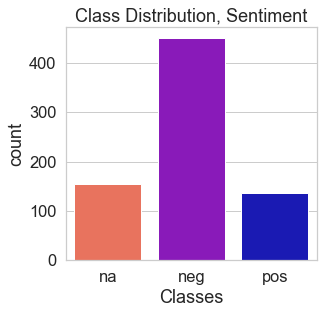

In [5]:
print(y_train_sent["y_sent"].value_counts())
print(y_val_sent["y_sent"].value_counts())

#plot class distribution
plt.figure(figsize=(4, 4))
plot_colors = ['tomato','darkviolet','mediumblue']
ax = sns.countplot(x=y_train_sent["y_sent"], palette=plot_colors).set_xticklabels(["na", "neg", "pos"])
plt.xlabel('Classes')
plt.title('Class Distribution, Sentiment');

Majority class = negative = 1

Now use that as the prediction.

In [6]:
# Get the groundtruth - For all of them...
true = list(y_train_sent["y_sent"])

In [7]:
# NOTE: Function which takes two lists and a reference indicating which class to calculate the TP, FP, and FN for.
# aa.classConfScores(y_true, y_pred, reference)

# NOTE: A function which takes the precision and recall of some model, and a value for beta, and returns the f_beta-score"""
# aa.fBetaScore(precision, recall, beta=1)

# Make a list of 1s as long as the training set to function as our base prediction.
maj_pred = [1 for i in range(len(y_train_sent))]

## Find the microaverage of the F1 scores for the balseline prediction
majority_microF1 = f1_score(y_true=true, y_pred=maj_pred, average='micro', zero_division='warn')
majority_macroF1 = f1_score(y_true=true, y_pred=maj_pred, average='macro', zero_division='warn')

### Get per-class values (only works for the prediced class right now - division by zero)
# Use that list to find the confusion matrix values.
(TP, FP, FN) = aa.classConfScores(true, maj_pred, 1)
# Use the confusion scores to find precision, recall, and the F1 score
p = TP / (TP + FP)
r = TP / (TP + FN)
f = aa.fBetaScore(precision=p, recall=r, beta=1)  # takes the precision and recall of some model, and a value for beta

### Print it all out
print("Micro- and Macro-Average")
print('\tMajority class prediction F-score, micro average: {:04.3f}'.format(majority_microF1))
print('\tMajority class prediction F-score, macro average: {:04.3f}'.format(majority_macroF1))
print('')
print('class: {:d}'.format(1))
print('\tPrecision: {:04.3f}'.format(p))
print('\tRecall: {:04.3f}'.format(r))
print('\tF-score: {:04.3f}'.format(f))

Micro- and Macro-Average
	Majority class prediction F-score, micro average: 0.606
	Majority class prediction F-score, macro average: 0.252

class: 1
	Precision: 0.606
	Recall: 1.000
	F-score: 0.755


# VADER Out of the Box
No data celaning specific to VADER / Sentiment analysis. No tuning of VADER's tools. No fancy emojis (only keyboard).

VADER is case sensitive and punctuation sensitive.

First create a new variable for vader. Then run the function.

In [49]:
# x_train.drop(columns = ["VADERsid", "VADERcompound", "VADERpred"], axis = 1, inplace = True)
# x_train.head()

,id_stable,Date,Content,ContentClean
108,13340,2022-03-02 02:24:19+00:00,@pjoreterffery Yeah I mean I think squeezing t...,yeah i mean i think squeezing the afghan peopl...
1012,20675,2022-02-04 23:37:50+00:00,@saverayan1 How sweet and this poor little one...,how sweet and this poor little one looks to be...
772,63713,2021-09-27 14:25:01+00:00,Biden's vetted Afghanistan refugees are commit...,biden's vetted afghanistan refugees are commit...
934,70672,2021-09-18 17:45:32+00:00,@MoBrooks You're talking about Trump who:\n• S...,you're talking about trump who: • surrendered ...
450,50394,2021-10-26 01:23:10+00:00,How can Canada best deliver on its commitment ...,how can canada best deliver on its commitment ...


In [8]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(aa.vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(aa.vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(aa.vader_pred)
x_train.tail()

,id_stable,Date,Content,ContentClean,VADERsid,VADERcompound,VADERpred
506,25533,2022-01-16 18:30:03+00:00,@AP Ok let the questions being. Did the Terror...,Ok let the questions being. Did the Terrorist ...,"{'neg': 0.235, 'neu': 0.721, 'pos': 0.044, 'co...",-0.8900,1
769,106799,2021-08-28 10:13:32+00:00,@campbellclaret Sooooooo agree!\nNow then talk...,Sooooooo agree! Now then talk us through Afgha...,"{'neg': 0.21, 'neu': 0.67, 'pos': 0.12, 'compo...",-0.4389,1
712,183663,2021-07-22 14:58:14+00:00,"Today I’m voting to pass the ALLIES Act, which...","Today I’m voting to pass the ALLIES Act, which...","{'neg': 0.0, 'neu': 0.773, 'pos': 0.227, 'comp...",0.8176,2
102,66047,2021-09-23 22:47:43+00:00,"@POTUS\nMan, I know this migrant thing is bad ...","Man, I know this migrant thing is bad but coul...","{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'comp...",-0.6641,1
679,177479,2021-08-09 10:58:28+00:00,@hassib_haidar why is Afghan army clicking pic...,why is Afghan army clicking pictures of terror...,"{'neg': 0.214, 'neu': 0.72, 'pos': 0.066, 'com...",-0.8020,1


In [9]:
print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

Ground Truth:
1    450
0    155
2    137
Name: y_sent, dtype: int64
Pred:
2    319
1    293
0    130
Name: VADERpred, dtype: int64


Note that I'm 
* Slightly underpredicting 0 / neutral
* Underpredicting 1 / negative
* Overpredicting 2 / positive
### Score: VADER-base, untuned

In [ ]:
## ALT FN, see below
tweets_clean["VADERsid"] = tweets_clean["ContentClean"].apply(aa.vader_sid)
tweets_clean["VADERcompound"] = tweets_clean["ContentClean"].apply(aa.vader_sent_compound)
tweets_clean["VADERpred"] = tweets_clean["ContentClean"].apply(aa.vader_pred)

# Get the prediction and the grounttruth as lists
demoji_pred = list(tweets_clean["VADERpred"])
true = list(tweets_clean["y_sent"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=demoji_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=demoji_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-demoji F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-demoji F-score, macro average: {:04.3f}'.format(base_macroF1))

In [10]:
# NOTE: Function which takes two lists and a reference indicating which class to calculate the TP, FP, and FN for.
# aa.classConfScores(y_true, y_pred, reference)

# Use the same "true" as above
# Get the prediction list
untuned_pred = list(x_train["VADERpred"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=untuned_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=untuned_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-base F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-base F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

# Get the per-class scores
for t in range(3): # Go over our three classes, 0=na, 1=neg, 2=pos
    (TP, FP, FN) = aa.classConfScores(true, untuned_pred, t)
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    f = aa.fBetaScore(precision=p, recall=r, beta=1)  # takes the precision and recall of some model, and a value for beta
    
    print('class: {:d}'.format(t))
    print('\tPrecision: {:04.3f}'.format(p))
    print('\tRecall: {:04.3f}'.format(r))
    print('\tF-score: {:04.3f}'.format(f))
    print('')


Micro and Macro-Average
	VADER-base F-score, micro average: 0.543
	VADER-base F-score, macro average: 0.502

class: 0
	Precision: 0.446
	Recall: 0.374
	F-score: 0.407

class: 1
	Precision: 0.833
	Recall: 0.542
	F-score: 0.657

class: 2
	Precision: 0.317
	Recall: 0.737
	F-score: 0.443



In [11]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)
train_temp.head()

(742, 4)


,id_stable,VADERcompound,VADERpred,GroundTruth
108,13340,0.2960,2,1
1012,20675,-0.8750,1,1
772,63713,0.0772,2,1
934,70672,-0.7579,1,1
450,50394,0.8846,2,0


In [12]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

,count,mean,std,min,25%,50%,75%,max
GroundTruth,,,,,,,,
0,155.0,0.123073,0.408238,-0.8591,0.00000,0.0000,0.42150,0.9001
1,450.0,-0.133040,0.550893,-0.9779,-0.64835,-0.1779,0.33955,0.9501
2,137.0,0.364921,0.444353,-0.9331,0.00000,0.4336,0.70960,0.9677


VADER Compound Score grouped by Ground Truth


<AxesSubplot:title={'center':'VADERcompound'}, xlabel='GroundTruth'>

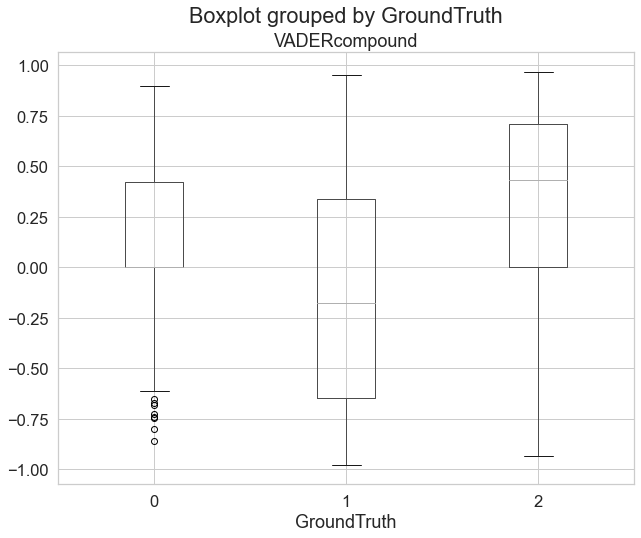

In [13]:
# train_temp.groupby('GroundTruth')['VADERcompound'].describe()
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

Note that the neutral (class 0) and positive (class 2) ground truth have overlapping VADERcompund scores in a not great way. And the negative (class 1) is spanning a lot of ground.

We need more separation before we can choose good threshhold values. Though I imagine we could do a bit better even now, just by choosing 0 and 0.25 as our thresholds.

### PAUSE / UNPAUSE

In [174]:
# PAUSE
x_train.to_csv(os.path.join('dataVader', "x_train_VADER.csv"))
x_val.to_csv(os.path.join('dataVader', "x_val_VADER.csv"))

In [17]:
# UNPAUSE
x_train = pd.read_csv(os.path.join('dataVader', "x_train_VADER.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_VADER.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)


# Data Prep
VADER should do better if we get the input into better shape.

### What if we use the ContentClean column that we used for labeling?
Remember that VADER has its own way of dealing with punctuation, capitalization, modifiers, negations, stopwords, tokenization and lemmatization. Earlier cleaning was done to try not to mess with that. Let's make sure that was done correctly.

(A nice tutorial explaining this: https://towardsdatascience.com/are-you-scared-vader-understanding-how-nlp-pre-processing-impacts-vader-scoring-4f4edadbc91d)

In [175]:
x_train["VADERsid"] = x_train["ContentClean"].apply(vader_sid)
x_train["VADERcompound"] = x_train["ContentClean"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["ContentClean"].apply(vader_pred)
x_train.tail()

,id_stable,Date,Content,ContentClean,VADERsid,VADERcompound,VADERpred
506,25533,2022-01-16 18:30:03+00:00,@AP Ok let the questions being. Did the Terror...,Ok let the questions being. Did the Terrorist ...,"{'neg': 0.24, 'neu': 0.715, 'pos': 0.045, 'com...",-0.8900,1
769,106799,2021-08-28 10:13:32+00:00,@campbellclaret Sooooooo agree!\nNow then talk...,Sooooooo agree! Now then talk us through Afgha...,"{'neg': 0.221, 'neu': 0.654, 'pos': 0.126, 'co...",-0.4389,1
712,183663,2021-07-22 14:58:14+00:00,"Today I’m voting to pass the ALLIES Act, which...","Today I’m voting to pass the ALLIES Act, which...","{'neg': 0.0, 'neu': 0.773, 'pos': 0.227, 'comp...",0.8176,2
102,66047,2021-09-23 22:47:43+00:00,"@POTUS\nMan, I know this migrant thing is bad ...","Man, I know this migrant thing is bad but coul...","{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...",-0.6641,1
679,177479,2021-08-09 10:58:28+00:00,@hassib_haidar why is Afghan army clicking pic...,why is Afghan army clicking pictures of terror...,"{'neg': 0.218, 'neu': 0.714, 'pos': 0.067, 'co...",-0.8020,1


In [176]:
# Get the prediction and the grounttruth as lists
base_pred = list(x_train["VADERpred"])
true = list(y_train_sent["y_sent"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=base_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=base_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-base F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-base F-score, macro average: {:04.3f}'.format(base_macroF1))

Micro and Macro-Average
	VADER-base F-score, micro average: 0.543
	VADER-base F-score, macro average: 0.502


Good: that's the same. 

I'll work from the ContentClean column then.

# Emoji
### Emojis: ref: vaderEmoji.ipynb
So, how does VADER actually handel some of these emoji?

In [ ]:
sid = SentimentIntensityAnalyzer()

txt = "I strongly support your relocation from Afgh."
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. 👍"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. :thumbs_up:"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. Thumbs up."
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. Thumbs up!"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. Thumbs down!"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. !"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. :)"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. 🤣"
print(aa.vader_sent_compound(txt))

print()

txt = "I hate your relocation from Afgh."
print(aa.vader_sent_compound(txt))
txt = "I hate your relocation from Afgh. Thumbs down"
print(aa.vader_sent_compound(txt))
txt = "I hate your relocation from Afgh. Thumbs down!"
print(aa.vader_sent_compound(txt))

Note that all four of the first sentences get the same score. But when we add ":)", the score jumps up.

Note that 🤣 is scored but 👍 is not.

Adding an exclamation point increases the score, but unfortunately it doesn't distinguish between up and down. I think it's just giving the score a boost for the "!". Yep, it is.

So... How many and what scores does VADER give?

In [ ]:
emoji_df_full["VADERscore"] = emoji_df_full["emoji"].apply(aa.vader_sent_compound)
print(emoji_df_full["VADERscore"].value_counts())
emoji_df_full

Well, it gets some (165 of 1106) of them, but misses (941) a few that might be important to us (🤡, for example)

And some are really not correct for our data:
* 💔, :broken_heart:, 0.2732 --> -0.2732
* 😔, :pensive_face:, 0.0772 --> -0.1
* 😥, :sad_but_relieved_face: 0.3291 --> -0.1

There are a few ways we could deal with this.
1. Take the emojized version and transform it so 👍 --> Thumbs up!  (or just "!", it's the same score)
2. Translate to keyboard emoji, so 👍 --> :)
3. Add the emoji to the dictionary and give them our own score.
4. Add the emoji to the dictionary, but give them emosent scores (https://pypi.org/project/emosent-py/)

Trying a fw out on just the labeled dataset.

Of these, I think my best bet is #1. It's not perfect, but it requires the fewest assumptions and thus the least validating. Start there.

In [ ]:
text = "I strongly support 👍your relocation from Afgh.👍"
print(text)
print(aa.vader_sent_compound(text))

text = aa.emojiToExcl(text)
print()
print(text)
print(aa.vader_sent_compound(text))

In [ ]:
tweets_clean['ContentCleanEx'] = tweets_clean['ContentClean'].apply(aa.emojiToExcl)

In [ ]:
print(aa.term_check("❤️", tweets_clean, text_col="ContentClean"))
print(aa.term_check("❤️", tweets_clean, text_col="ContentCleanEx"))
print(aa.term_check("!", tweets_clean, text_col="ContentClean"))
print(aa.term_check("!", tweets_clean, text_col="ContentCleanEx"))

In [ ]:
tweets_clean["VADERsid"] = tweets_clean["ContentCleanEx"].apply(aa.vader_sid)
tweets_clean["VADERcompound"] = tweets_clean["ContentCleanEx"].apply(aa.vader_sent_compound)
tweets_clean["VADERpred"] = tweets_clean["ContentCleanEx"].apply(aa.vader_pred)

# Get the prediction and the grounttruth as lists
demoji_pred = list(tweets_clean["VADERpred"])
true = list(tweets_clean["y_sent"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=demoji_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=demoji_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-excl F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-excl F-score, macro average: {:04.3f}'.format(base_macroF1))

In [184]:
## DEL: duplicate of above?
x_train["VADERsid"] = x_train["ContentClean"].apply(vader_sid)
x_train["VADERcompound"] = x_train["ContentClean"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["ContentClean"].apply(vader_pred)

# Get the prediction and the grounttruth as lists
demoji_pred = list(x_train["VADERpred"])
true = list(y_train_sent["y_sent"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=demoji_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=demoji_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-demoji F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-demoji F-score, macro average: {:04.3f}'.format(base_macroF1))

Micro and Macro-Average
	VADER-demoji F-score, micro average: 0.542
	VADER-demoji F-score, macro average: 0.501


Well, that actually made it a tiny bit worse, still below the baseline.

VADER-base, untuned
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

Emoji to Exclamation
* VADER-demoji F-score, micro average: 0.542
* VADER-demoji F-score, macro average: 0.501

I'm guessing that is because the way I have done it, the exclamation point just pushes the score a bit further in the direction it was going anyway. Since the neutral category is so small to begin with, this just doesn't do much. 

But at the same time, I did this for ALL emojis, so it lost the validated score on the few emojis that VADER did know.

This is not a good approach. 

In [ ]:
tweets_clean.drop("ContentCleanEx", axis=1, inplace=True)
tweets_clean.head()

### Emosent
Will the emosent package work for me?

In [140]:
emoji_df_full["emosentScore"] = emoji_df_full["emoji"].apply(aa.emosent_score)
emoji_df_full

# CITE: Sentiment of Emojis, Nova et. al.

,emoji,demoji,emosentScore
0,💔,:broken_heart:,-0.122
1,❤️,:red_heart:,
2,🤔,:thinking_face:,
3,👉,:backhand_index_pointing_right:,0.394
4,🌎,:globe_showing_Americas:,0.341
...,...,...,...
1101,👈🏾,:backhand_index_pointing_left_medium-dark_skin...,
1102,🕎,:menorah:,
1103,🔯,:dotted_six-pointed_star:,1.0
1104,🤝🏼,:handshake_medium-light_skin_tone:,


In [ ]:
print(emoji_df_full["emosentScore"].value_counts())

Kinda. It has about half (missing 638) . But it seems to miss some of the important ones that I need. 
* 🤷, 🤮, etc.

And for the symbols where they overlap, the VADER and emosent scores do necessarilly agree and are sometimes very far off:
* 💔 (broken_heart): 0.2732 v. -0.122
* 😭 (loudly_crying_face): -0.4767 v. -0.093

And some of the values are just off for __this__ dataset. For example, the stack of dollars (💵) has a emosent score of 0.423 - very high. Which makes sense normally: money is good. But in this dataset, it shows up when people are stressing the overly high cost of refugee or ilitary operations, or are talking about corruption. 

As this tool has been validated, I'll consider the values they have. But I'll still have to assign my own values to the remaining half. So: first VADER; if not, then emosent; if not, then my ranking; and my own ranking for emojis that are used differently than normal in my dataset.

NOTE: I will have to add the emosent and my emojis to the dictionary. 
* For more insight on ranking: http://kt.ijs.si/data/Emoji_sentiment_ranking/

NOTE: There is a LOT more that could be done with emojis in terms of: 
* setting sentiment scores for all emoji that appear in the dataet, not just in my labeled subset.
* identifying news articles and other irrelevant rows in the data.

For now, write them to a CSV file for later labeling.

In [141]:
emoji_df.to_csv(os.path.join('dataVader', "emoji_score.csv"))
#emoji_df_full.to_csv(os.path.join('dataVader', "emoji_score_full.csv"))

For now, let's reload the data and move on.
### PAUSE / UNPAUSE

In [22]:
# Unpause
x_train = pd.read_csv(os.path.join('dataVader', "x_train_VADER.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_VADER.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)

# Word Clouds
__NOTE: There is a lot of preprocessing below that is ONLY used to make the wordclouds. VADER has it's own way of dealing with things like punctuation, capitalization, stopwords, tokenization, lemmatization. And we don't necessarilly want to mass with / override that without validating.__

In order to refine the dictionaries, I need to know what words and bigrams/trigrams are common in which datasets. So let's make word clouds.

First I need to create a single text per pos, neg, and neutral. Then I can feed them into wordcloud. I think I'll use the full dataset to generate one, too.

I don't have a preexisting df for this, so I'm going to have to rebuild it. Sigh.

First just all the ContentClean

In [20]:
# SETUP

# changes to tokenizer and lemmatizer --> UPDATE in aardvark, too.
w_tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#stopwords = list(STOPWORDS) + ["Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now"]
stopwords = nltkStop.words('english') + ["Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "say", "like", "via"]

In [17]:
# start from the two sets - unlabeled and labeled - that were created in dataCleaningB
all_l = pd.read_csv("all_labeled_tweets.csv", header=0, index_col=0)
all_u = pd.read_csv("all_unlabeled_tweets.csv", header=0, index_col=0)
print(list(all_l.columns))
print(list(all_u.columns))

['id_stable', 'Date', 'Content', 'ContentClean', 'Labels', 'label_sent', 'y_sent', 'label_stance', 'y_stance', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Flag']
['id_stable', 'Date', 'Content', 'ContentClean', 'Flag']


In [18]:
l_list = ['Content','Labels', 'label_sent', 'y_sent', 'label_stance', 'y_stance', 'Flag', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags']
all_l.drop(l_list, axis=1, inplace=True)
print(list(all_l.columns))

u_list = ['Content', 'Flag']
all_u.drop(u_list, axis=1, inplace=True)
print(list(all_u.columns))

['id_stable', 'Date', 'ContentClean']
['id_stable', 'Date', 'ContentClean']


In [21]:
#NOTE that I'm ordering here by date. Not sure why...

frames = [all_l, all_u]
master_tweets = pd.concat(frames)
master_tweets.sort_values(by=['Date'], inplace=True)
master_tweets.reset_index(drop=True, inplace=True)
print(master_tweets.shape)
master_tweets.tail()

(201145, 3)


,id_stable,Date,ContentClean
201140,4,2022-04-27 08:27:05+00:00,Germany is displacing Afghan refugees to make ...
201141,3,2022-04-27 08:45:30+00:00,"got mine for the family business, lot of pacif..."
201142,2,2022-04-27 09:08:47+00:00,🗓️27 April 22 📰Daily news brief | #Afghanistan...
201143,1,2022-04-27 09:29:47+00:00,What is the difference between Afghan refugee ...
201144,0,2022-04-27 09:37:51+00:00,"Thank you so much for your condolences, unfort..."


### PAUSE / UNPAUSE

In [66]:
# Pause
master_tweets.to_csv(os.path.join('dataVader', "master_tweets.csv"))

In [203]:
# Unpause
master_tweets = pd.read_csv(os.path.join('dataVader', "master_tweets.csv"), header=0, index_col=0)

### Full Data Wordcloud
from the full dataset, stopwords removed

In [22]:
# Thanks to: https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html
train_words = ' '.join(master_tweets["ContentClean"])
a = aa.lemmatize_text(train_words)
lem_words = ' '.join(a)

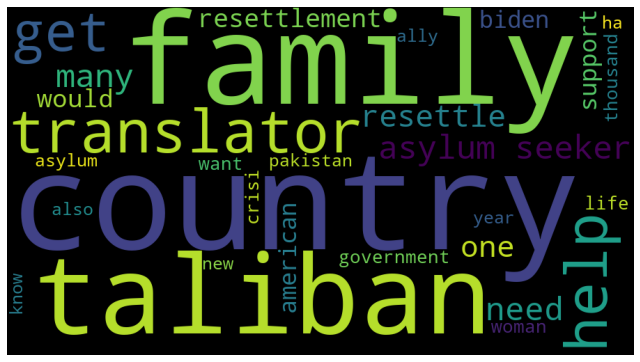

In [23]:
# CITE: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words)
all_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

# Word cloud by label
Now the labeled data, divied up by label.

In [25]:
all_xy = pd.read_csv(os.path.join('data', "all_labeled_tweets.csv"), header=0, index_col=0)
print(list(all_xy.columns))

['id_stable', 'Date', 'Content', 'ContentClean', 'Labels', 'label_sent', 'y_sent', 'label_stance', 'y_stance', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Flag']


In [26]:
d = ['Content', 'Labels', 'label_sent', 'label_stance', 'y_stance', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Flag']
master_labeled = all_xy.drop(d, axis=1)
master_labeled.sort_values(by=['Date'], inplace=True)
master_labeled.reset_index(drop=True, inplace=True)
print(master_labeled.shape)
master_labeled.tail()

(1061, 4)


,id_stable,Date,ContentClean,y_sent
1056,752,2022-04-22 13:11:59+00:00,Compared to the limited number of Afghan refug...,1
1057,612,2022-04-23 07:25:09+00:00,Happy St George’s Day y’all! - Let’s be kind a...,2
1058,510,2022-04-23 22:07:58+00:00,"🧵 Listen up Afg diaspora, there is a genocide ...",1
1059,494,2022-04-24 00:34:26+00:00,"Yes, Ann Linde, Please please use your influen...",1
1060,454,2022-04-24 09:21:23+00:00,If it’s legal you said you like economic migra...,2


In [27]:
labeled_zero = master_labeled[master_labeled["y_sent"]==0].copy()  # neu
labeled_one = master_labeled[master_labeled["y_sent"]==1].copy()  # neg
labeled_two = master_labeled[master_labeled["y_sent"]==2].copy()  # pos
print(labeled_zero.shape)
print(labeled_one.shape)
print(labeled_two.shape)

(221, 4)
(644, 4)
(196, 4)


### PAUSE / UNPAUSE

In [209]:
# Pause
master_labeled.to_csv(os.path.join('dataVader', "master_labelel.csv"))
labeled_zero.to_csv(os.path.join('dataVader', "labeled_zero.csv"))
labeled_one.to_csv(os.path.join('dataVader', "labeled_one.csv"))
labeled_two.to_csv(os.path.join('dataVader', "labeled_two.csv"))

### Preprocess for wordcloud: Tokenize and Lemmatize 

In [28]:
zero_words = ' '.join(labeled_zero["ContentClean"])
zero_lem = aa.lemmatize_text(zero_words)
zero_lem = ' '.join(zero_lem)

one_words = ' '.join(labeled_one["ContentClean"])
one_lem = aa.lemmatize_text(one_words)
one_lem = ' '.join(one_lem)

two_words = ' '.join(labeled_two["ContentClean"])
two_lem = aa.lemmatize_text(two_words)
two_lem = ' '.join(two_lem)

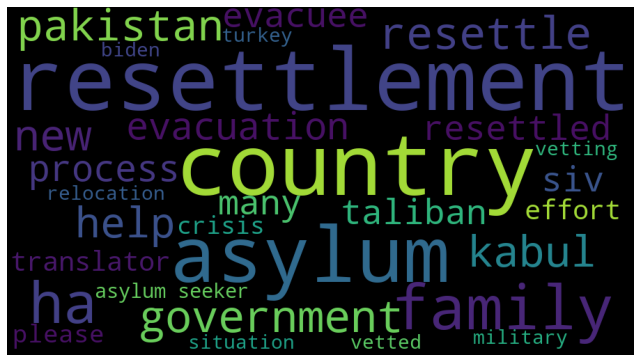

In [29]:
# Neutral
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(zero_lem)
neu_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

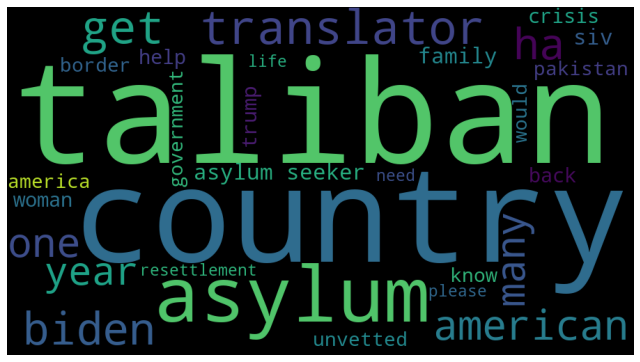

In [30]:
# Negative
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(one_lem)
neg_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

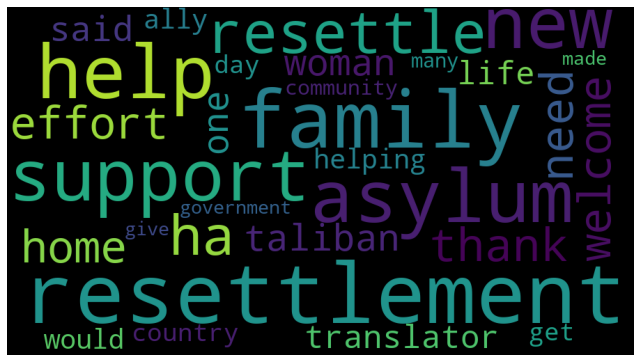

In [31]:
# Positive
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(two_lem)
pos_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

Significant in all three:
* asylum (this is surprising)
* "ha" is in both pos and neg. Does Vader catch this as sarcastic in the neg? This should be an intensifier, not a sentiment.

Add negiative score to:
* Taliban
* unvetted
* left behind
* crisis

Add positive score to:
* community
* help/ing (and why are these not fied by the lemmatizer?)
* family (this is in neutral too, but I think it might help w positive)
* resettlement (this is in neg, but really small... and in neu, maybe slightly positive)
* Thank
* welcome
* support
* opportunity

### Bigrams and Trigrams

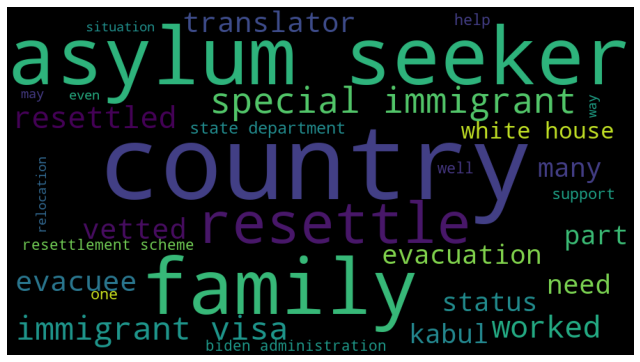

In [32]:
# Neutral - up to trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(zero_lem)
neu_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [33]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = zero_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_neu = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_neu, tri_neu = aa.bi_tri_freq(ngram_text_neu)
print("Neutral nGrams")
print(bi_neu[:25])
print()
print(tri_neu[:25])


Neutral nGrams
[('asylum seeker', 11), ('special immigrant', 10), ('afghan evacuee', 10), ('immigrant visa', 9), ('afghan resettlement', 7), ('afghan asylum', 6), ('afghan family', 6), ('white house', 6), ('state department', 6), ('biden administration', 5), ('afghan worked', 5), ('resettlement scheme', 5), ('resettle afghan', 5), ('second largest', 4), ('afghan special', 4), ('afghan ally', 4), ('siv applicant', 4), ('united state', 4), ('many afghan', 4), ('situation afghanistan', 4), ('uk government', 4), ('vulnerable afghan', 4), ('afghan migrant', 4), ('afghan woman', 4), ('demand answer', 4)]

[('special immigrant visa', 9), ('afghan asylum seeker', 6), ('afghan special immigrant', 4), ('immigrant visa program', 3), ('country life threatening', 2), ('life threatening situation', 2), ('afghan siv applicant', 2), ('consulate mazar sharif', 2), ('mazar sharif relocation', 2), ('uk ex military', 2), ('ex military chief', 2), ('security situation kabul', 2), ('airport pick ups', 2), (

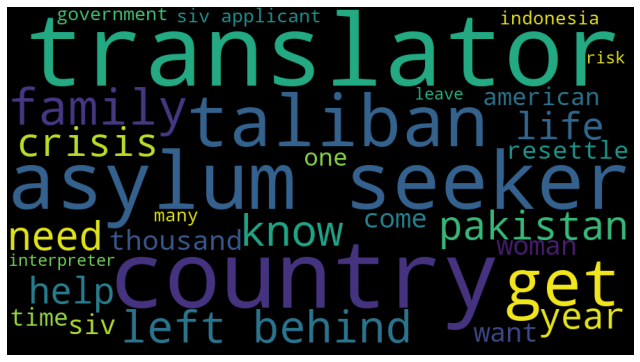

In [34]:
# Negative, trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(one_lem)
neg_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [35]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = one_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_neg = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_neg, tri_neg = aa.bi_tri_freq(ngram_text_neg)
print("Negative nGrams")
print(bi_neg[:25])
print()
print(tri_neg[:25])


Negative nGrams
[('asylum seeker', 43), ('afghan translator', 28), ('left behind', 22), ('unvetted afghan', 14), ('afghan asylum', 12), ('thousand afghan', 12), ('siv applicant', 12), ('afghan ally', 11), ('siv process', 10), ('anti immigrant', 10), ('afghan interpreter', 9), ('many afghan', 9), ('immigrant visa', 9), ('seeking asylum', 9), ('afghan woman', 9), ('united state', 9), ('iraq afghanistan', 8), ('please help', 8), ('special immigrant', 8), ('afghan army', 8), ('asylum afghan', 8), ('american citizen', 8), ('southern border', 8), ('dont want', 8), ('woman child', 7)]

[('afghan asylum seeker', 10), ('special immigrant visa', 8), ('osama bin laden', 4), ('afghan translator family', 4), ('asylum seeker afghanistan', 4), ('applicant left behind', 4), ('million per day', 4), ('afghan risked life', 3), ('thousand afghan translator', 3), ('iraq afghanistan libya', 3), ('life or death', 3), ('siv applicant family', 3), ('left behind afghanistan', 3), ('taxpayer money resettle', 3),

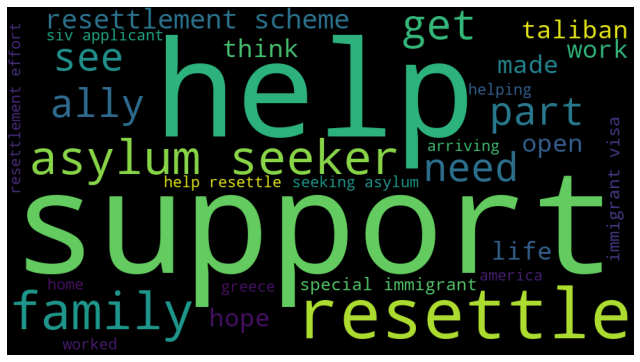

In [36]:
# Positive, trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(two_lem)
pos_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [37]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = two_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_pos = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_pos, tri_pos = aa.bi_tri_freq(ngram_text_pos)
print("Neutral nGrams")
print(bi_pos[:15])
print()
print(tri_pos[:15])

Neutral nGrams
[('resettle afghan', 10), ('asylum seeker', 9), ('afghan asylum', 7), ('afghan translator', 7), ('afghan resettlement', 7), ('afghan ally', 6), ('resettlement scheme', 6), ('afghan family', 6), ('special immigrant', 5), ('immigrant visa', 5), ('help resettle', 5), ('help afghan', 5), ('afghan interpreter', 4), ('seeking asylum', 4), ('afghan woman', 4)]

[('special immigrant visa', 5), ('afghan asylum seeker', 4), ('refugee turned soccer', 3), ('afghan citizen resettlement', 3), ('citizen resettlement scheme', 3), ('afghan asylum seeking', 2), ('asylum seeking father', 2), ('form non muslims', 2), ('non muslims living', 2), ('afghan found motorway', 2), ('good news afghan', 2), ('biscuit middle eastern', 2), ('middle eastern cake', 2), ('help resettle afghan', 2), ('west high profile', 2)]


In [38]:
# dictionary of the words used to make the cloud
neu_wc
neu_words = []
for key, val in neu_wc.items():
    neu_words.append(key)

neu_bi_wc
neu_bigs = []
for key, val in neu_bi_wc.items():
    neu_bigs.append(key)

neg_wc
neg_words = []
for key, val in neg_wc.items():
    neg_words.append(key)

neg_bi_wc
neg_bigs = []
for key, val in neg_bi_wc.items():
    neg_bigs.append(key)

pos_wc
pos_words = []
for key, val in pos_wc.items():
    pos_words.append(key)

pos_bi_wc
pos_bigs = []
for key, val in pos_bi_wc.items():
    pos_bigs.append(key)

wc_words = pd.DataFrame({"neu words":neu_words, "neg words":neg_words, "pos words":pos_words, "neu nGrams":neu_bigs, "neg nGrams":neg_bigs, "pos nGrams":pos_bigs})
wc_words[:15]

,neu words,neg words,pos words,neu nGrams,neg nGrams,pos nGrams
0,resettlement,taliban,resettlement,country,translator,support
1,country,country,family,asylum seeker,country,help
2,asylum,asylum,help,family,asylum seeker,resettle
3,family,translator,asylum,resettle,taliban,family
4,ha,get,support,special immigrant,get,asylum seeker
5,government,biden,new,immigrant visa,family,get
6,resettle,ha,resettle,worked,left behind,need
7,kabul,american,ha,resettled,know,part
8,new,one,need,vetted,pakistan,ally
9,pakistan,many,thank,translator,need,see


In [39]:
print("Neutral nGrams")
print(bi_neu[:10])
print(tri_neu[:10])
print()
print("Negative nGrams")
print(bi_neg[:10])
print(tri_neg[:10])
print()
print("Positive nGrams")
print(bi_pos[:10])
print(tri_pos[:10])


Neutral nGrams
[('asylum seeker', 11), ('special immigrant', 10), ('afghan evacuee', 10), ('immigrant visa', 9), ('afghan resettlement', 7), ('afghan asylum', 6), ('afghan family', 6), ('white house', 6), ('state department', 6), ('biden administration', 5)]
[('special immigrant visa', 9), ('afghan asylum seeker', 6), ('afghan special immigrant', 4), ('immigrant visa program', 3), ('country life threatening', 2), ('life threatening situation', 2), ('afghan siv applicant', 2), ('consulate mazar sharif', 2), ('mazar sharif relocation', 2), ('uk ex military', 2)]

Negative nGrams
[('asylum seeker', 43), ('afghan translator', 28), ('left behind', 22), ('unvetted afghan', 14), ('afghan asylum', 12), ('thousand afghan', 12), ('siv applicant', 12), ('afghan ally', 11), ('siv process', 10), ('anti immigrant', 10)]
[('afghan asylum seeker', 10), ('special immigrant visa', 8), ('osama bin laden', 4), ('afghan translator family', 4), ('asylum seeker afghanistan', 4), ('applicant left behind', 4),

In [42]:
# Should have included this in the aardvark function. Oh well.
from sklearn.feature_extraction.text import CountVectorizer

words_in_text = list(ngrams(ngram_text_neu.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Neutral Tweets")
print(words_in_text_freq[:25])
print()

words_in_text = list(ngrams(ngram_text_neg.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Negative Tweets")
print(words_in_text_freq[:25])
print()

words_in_text = list(ngrams(ngram_text_pos.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Positive Tweets")
print(words_in_text_freq[:25])

Frequent Words: Neutral Tweets
[('afghan', 170), ('afghanistan', 82), ('asylum', 34), ('resettlement', 34), ('country', 29), ('family', 23), ('uk', 21), ('ha', 20), ('government', 17), ('state', 17), ('resettle', 17), ('kabul', 16), ('siv', 16), ('visa', 16), ('pakistan', 16), ('biden', 15), ('help', 15), ('evacuation', 14), ('process', 13), ('immigrant', 13), ('special', 12), ('resettled', 12), ('many', 12), ('taliban', 12), ('evacuee', 12)]

Frequent Words: Negative Tweets
[('afghan', 433), ('afghanistan', 284), ('asylum', 127), ('taliban', 93), ('country', 80), ('siv', 70), ('translator', 69), ('get', 64), ('biden', 64), ('american', 58), ('ha', 56), ('one', 49), ('many', 47), ('family', 47), ('help', 45), ('woman', 44), ('year', 44), ('seeker', 43), ('crisis', 43), ('back', 42), ('border', 41), ('trump', 41), ('resettlement', 41), ('left', 39), ('vetted', 38)]

Frequent Words: Positive Tweets
[('afghan', 159), ('afghanistan', 72), ('resettlement', 40), ('asylum', 35), ('family', 30

In [336]:
# Alternate approach: easier code, messier results.
from nltk.probability import FreqDist
pos_tok = ngram_text_pos.split(" ")
fdist = FreqDist(pos_tok)
fdist = fdist.most_common(5)
fdist

[('afghan', 159),
 ('afghanistan', 70),
 ('u', 44),
 ('resettlement', 40),
 ('asylum', 34)]

In [43]:
# check_tweets = pd.read_csv(os.path.join('dataVader', "master_labelel.csv"), index_col=0, header=0)
check_tweets = pd.read_csv(os.path.join('dataVader', "master_tweets.csv"), index_col=0, header=0)


### ALTERNATE term check

In [14]:
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🔜" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count
# Orig: left behind: 3992 instances in master_tweets

130672 : 🆘🔜✍🏾🆘🔜✍🏾🆘🔜🆘✍🏾 After 2 decades of war, the US and allies can’t turn their backs on Afghans now. Join the urgent global call for a massive refugee resettlement programme and relief effort now:
86135 : 🔜Anissa Bonnefont’s documentary that tells the story of an Afghan refugee who has become a world-renowned soccer star, will be screened at #VirtualScreeningsWorldwide It's a Création Documentaire film co-produced by
62060 : #StoriesFromThePitch⚽️ in 10min w/ talking soccer dropping 2 conference games + sign + Afghanistan ladies soccer finds asylum #TuneIn 🔜🔛💻 or 📱 #FStreamApp 🎙Podcast 🔛
29330 : 📣 JOB ANNOUNCEMENT: Fellowship Attorney Exciting news! MIRC received funding to lead a project to serve the many Afghans who need to apply for asylum within 1 year of arrival in U.S. APPLY by Jan 10 or share with someone who might be a good candidate!🔜


4

In [15]:
vader_sent_compound("embarrassing")

-0.3818

# Adding to VADER
### Stop Words 
VADER takes care of stop word removal. I would to refine what is considered a stopword, but that's surprisingly complicated. So instead we are going to change the lexicon to make the relevant words score = 0.

Add: all the ones that were used for WordCloud: "Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "ha", "say", "like", "via"

Also: "asylum", "seeker", "special", "family", "country"

In [45]:
sid = SentimentIntensityAnalyzer()
change_lex = {}

In [30]:
check_list = ["asylum", "seeker", "special", "family", "country", "Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "ha", "say", "like", "via"]
for i in check_list:
    print(i, ":", vader_sent_compound(i))  #💩

asylum : 0.0
seeker : 0.0
special : 0.4019
family : 0.0
country : 0.0
Afghan : 0.0
Afghans : 0.0
Afghanistan : 0.0
refugee : 0.0
refugees : 0.0
U : 0.0
S : 0.0
US : 0.0
people : 0.0
will : 0.0
now : 0.0
UK : 0.0
wa : 0.0
ha : 0.34
say : 0.0
like : 0.3612
via : 0.0


In [46]:
change_lex["special"]=0
change_lex["like"] = 0
change_lex["ha"] = 0
sid.lexicon.update(change_lex)
# "ha" is in both pos and neg (sarcastic); this should be an intensifier, not a sentiment.

### New Dictionary terms
emojis

negative: left behind, unvetted, Taliban, Osama bin Laden, crisis

Positive: soccer, citizen, help, support, thank, welcome, hope

Neutral: resettle, resettlement

#thanks: https://stackoverflow.com/questions/40481348/is-it-possible-to-edit-nltks-vader-sentiment-lexicon

In [47]:
check_list = ["left behind", "unvetted", "Taliban", "Laden", "crisis", "soccer", "citizen", "help", "support", "thank", "welcome", "hope", "resettle", "resettlement"]

for i in check_list:
    print(i, ":", vader_sent_compound(i))

left behind : 0.0
unvetted : 0.0
Taliban : 0.0
Laden : 0.0
crisis : -0.6249
soccer : 0.0
citizen : 0.0
help : 0.4019
support : 0.4019
thank : 0.3612
welcome : 0.4588
hope : 0.4404
resettle : 0.0
resettlement : 0.0


In [48]:
change_lex["left behind"] = -3
change_lex["unvetted"] = -2
change_lex["taliban"] = -1
change_lex["laden"] = -1  # In the full dataset, there are 123 " bin laden"s and 156 "laden"s; most of these are made up by just the most obvious misspellings (#osamabin: 6; binladen: 11; ben laden: 1). Good enough.
change_lex["soccer"] = 1
change_lex["citizen"] = 1
sid.lexicon.update(change_lex)

"left behind" needs to be changed into a single word for VADER to score it appropriately.

In [49]:
print(vader_sent_compound("left behind"))
change_lex["left_behind"] = 2
sid.lexicon.update(change_lex)
vader_sent_compound("left_behind")

0.0


0.4588

In [52]:
my_count = 0
for id, text in zip(check_tweets.id_stable, x_train["ContentClean"]):
    if "left behind" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        #print(id, ":", text)
        my_count += 1
print(my_count)

my_count = 0
for id, text in zip(check_tweets.id_stable, x_train["ContentClean"]):
    if "left_behind" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        #print(id, ":", text)
        my_count += 1
print(my_count)

0
15


In [51]:
for i, text in zip(x_train.index, x_train["ContentClean"]):
    x_train.loc[i, ["ContentClean"]] = text.lower().replace('left behind', 'left_behind')

### Now find the score

In [53]:
x_train.drop(columns = ["VADERsid", "VADERcompound", "VADERpred"], axis = 1, inplace = True)
x_train.head()

,id_stable,Date,Content,ContentClean
108,13340,2022-03-02 02:24:19+00:00,@pjoreterffery Yeah I mean I think squeezing t...,yeah i mean i think squeezing the afghan peopl...
1012,20675,2022-02-04 23:37:50+00:00,@saverayan1 How sweet and this poor little one...,how sweet and this poor little one looks to be...
772,63713,2021-09-27 14:25:01+00:00,Biden's vetted Afghanistan refugees are commit...,biden's vetted afghanistan refugees are commit...
934,70672,2021-09-18 17:45:32+00:00,@MoBrooks You're talking about Trump who:\n• S...,you're talking about trump who: • surrendered ...
450,50394,2021-10-26 01:23:10+00:00,How can Canada best deliver on its commitment ...,how can canada best deliver on its commitment ...


In [54]:

# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())


Ground Truth:
1    450
0    155
2    137
Name: y_sent, dtype: int64
Pred:
1    318
2    298
0    126
Name: VADERpred, dtype: int64


In [56]:
# Use the same "true" as above
# Get the prediction list
lex1_pred = list(x_train["VADERpred"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=lex1_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=lex1_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER_lex1 F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER_lex1 F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

Micro and Macro-Average
	VADER_lex1 F-score, micro average: 0.563
	VADER_lex1 F-score, macro average: 0.521



This is a little bit better, but really not much. And not over the baseline.
* Underpredicting neutral
* Underpredicting negative
* Overpredicting positive

Baseline: Majority Class Prediction
* Majority class prediction F-score, micro average: 0.606
* Majority class prediction F-score, macro average: 0.252

VADER-base, untuned:
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

VADER-base, lexicon with updated sentiment terms
* VADER_lex_ F-score, micro average: 0.563
* VADER_lex_ F-score, macro average: 0.521


In [57]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)

(742, 4)


In [58]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

,count,mean,std,min,25%,50%,75%,max
GroundTruth,,,,,,,,
0,155.0,0.079963,0.418306,-0.8591,-0.038700,0.0000,0.4117,0.9001
1,450.0,-0.176042,0.547400,-0.9779,-0.672525,-0.2570,0.2500,0.9501
2,137.0,0.346542,0.453034,-0.9331,0.000000,0.4215,0.7003,0.9640


VADER Compound Score grouped by Ground Truth


<AxesSubplot:title={'center':'VADERcompound'}, xlabel='GroundTruth'>

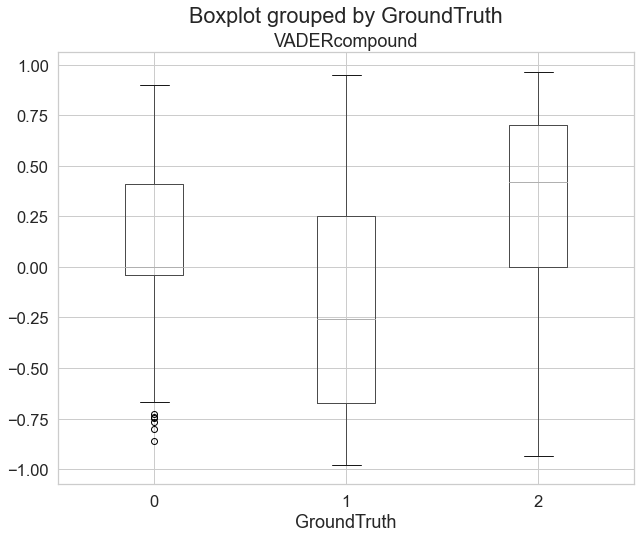

In [60]:
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

### PAUSE / UNPAUSE

In [89]:
# PAUSE
x_train.to_csv(os.path.join('dataVader', "x_train_VADERlex.csv"))
#x_val.to_csv(os.path.join('dataVader', "x_val_VADERlex.csv"))   NOT done yet 


In [ ]:
# UNPAUSE
x_train = pd.read_csv(os.path.join('dataVader', "x_train_VADERlex.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_VADERlex.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)

### Add new emojis to the lexicon

In [80]:
emoji_df = pd.read_csv(os.path.join('dataVader', "emoji_score.csv"), header=0, index_col=0)
emoji_lex = emoji_df[emoji_df["VADERscore"]==0].copy()
emoji_lex.drop("VADERscore", axis=1, inplace=True)
emoji_lex.head()

,emoji,demoji,emosentScore
1,❤️,:red_heart:,NaN
2,🤔,:thinking_face:,NaN
3,👉,:backhand_index_pointing_right:,0.394
4,🌎,:globe_showing_Americas:,0.341
5,💀,:skull:,-0.208


I'm going to do the scoring in Excel.

In [213]:
emoji_lex.to_csv("emoji_lex.csv")

In [81]:
emoji_lex2 = pd.read_csv(os.path.join('dataVader', "emoji_lex_myScore.csv"), header=0, index_col=0)
emoji_lex2.tail()

# emoji_lex2 = pd.read_csv("emoji_lex.csv", header=0, index_col=0)

,name,lexScore
68,raising_hands,0.5600
69,right_arrow,0.0000
70,my_broken_heart,-0.2732
71,pensive_face,-0.1000
72,sad_but_relieved,-0.2000


So, apparently VADER transforms emoji to text before extracting sentiment. I'm not exactly sure how this works: since it seems to map emoji to some pretty common words, I'm not sure how updating these sentiments would work. So I'm going to do the word transformation myself, then add those words to the lexicon with my scores.

In [71]:
# del emoji_lex
# del emoji_lex2

In [82]:
frames = [emoji_lex, emoji_lex2]
emoji_lex = pd.concat(frames, axis=1)
# emoji_lex.drop(columns=["demoji", "emosentScore"], inplace=True)
emoji_lex.drop(columns=["emoji", "demoji", "emosentScore"], inplace=True)
emoji_lex = emoji_lex[emoji_lex["lexScore"] != 0]
emoji_lex = dict(zip(emoji_lex["name"], emoji_lex["lexScore"]))
emoji_lex

{'red_heart': 0.5,
 'thinking_face': -0.05,
 'globe_showing_Americas': 0.1,
 'sk_ull': -0.208,
 'person_facepalming': -0.3,
 'cricket': -0.2,
 'folded_hands': 0.418,
 'globe_showing_Europe-Africa': 0.1,
 'double_exclamation_mark': 0.2,
 'flexed_biceps': 0.556,
 'face_with_rolling_eyes': -0.3,
 'recycling_symbol': 0.1,
 'woman_shrugging': -0.2,
 'flushed_face': -0.2,
 'pouting_face': -0.4,
 'star_struck': 0.4,
 'soccer_ball': 0.622,
 'woman_facepalming': -0.3,
 'face_with_symbols_on_mouth': -0.4,
 'dollar_banknote': -0.2,
 'folded_hands_light_skin_tone': 0.418,
 'middle_finger': -0.6,
 'pile_of_poo': -0.4,
 'clown_face': -0.3,
 'thumbs_up_medium-dark_skin_tone': 0.4,
 'globe_showing_Asia-Australia': 0.1,
 'face_without_mouth': -0.145,
 'person_shrugging': -0.2,
 'man_shrugging': -0.2,
 'raising_hands': 0.56,
 'my_broken_heart': -0.2732,
 'pensive_face': -0.1,
 'sad_but_relieved': -0.2}

In [85]:
sid.lexicon.update(emoji_lex)

In [88]:
print(vader_sent_compound("person_shrugging"))
print(vader_sent_compound("clown_face"))
print(vader_sent_compound("my_broken_heart"))

-0.0516
-0.0772
-0.0704


So that works to update VADER.

Now to make the transformation in the data.

In [89]:
a = emoji_df[emoji_df["VADERscore"]==0].copy()
a.drop("VADERscore", axis=1, inplace=True)
a.tail()

,emoji,demoji,emosentScore
63,😶,:face_without_mouth:,-0.145
66,🤷,:person_shrugging:,NaN
67,🤷‍♂️,:man_shrugging:,NaN
68,🙌,:raising_hands:,0.560
69,➡,:right_arrow:,0.149


In [99]:
frames = [a, emoji_lex2]
emoji_dataUpdate = pd.concat(frames, axis=1)
emoji_dataUpdate.tail()

,emoji,demoji,emosentScore,name,lexScore
68,🙌,:raising_hands:,0.560,raising_hands,0.5600
69,➡,:right_arrow:,0.149,right_arrow,0.0000
70,NaN,NaN,NaN,my_broken_heart,-0.2732
71,NaN,NaN,NaN,pensive_face,-0.1000
72,NaN,NaN,NaN,sad_but_relieved,-0.2000


In [100]:
emoji_dataUpdate.loc[70, "emoji"] = "💔"
emoji_dataUpdate.loc[71, "emoji"] = "😔"
emoji_dataUpdate.loc[72, "emoji"] = "😥"
emoji_dataUpdate.tail()

,emoji,demoji,emosentScore,name,lexScore
68,🙌,:raising_hands:,0.560,raising_hands,0.5600
69,➡,:right_arrow:,0.149,right_arrow,0.0000
70,💔,NaN,NaN,my_broken_heart,-0.2732
71,😔,NaN,NaN,pensive_face,-0.1000
72,😥,NaN,NaN,sad_but_relieved,-0.2000


In [101]:
emoji_dataUpdate.drop(columns=["demoji", "emosentScore", "lexScore"], inplace=True)
emoji_dataUpdate.tail()

,emoji,name
68,🙌,raising_hands
69,➡,right_arrow
70,💔,my_broken_heart
71,😔,pensive_face
72,😥,sad_but_relieved


### PAUSE / UNPAUSE

In [257]:
x_train.to_csv(os.path.join('dataVader', "temp_x_train.csv"))

In [154]:
x_train = pd.read_csv(os.path.join('dataVader', "temp_x_train.csv"), index_col=0, header=0)
x_train.tail()

,id_stable,Date,Content,ContentClean,VADERsid,VADERcompound,VADERpred
506,25533,2022-01-16 18:30:03+00:00,@AP Ok let the questions being. Did the Terror...,ok let the questions being. did the terrorist ...,"{'neg': 0.284, 'neu': 0.674, 'pos': 0.042, 'co...",-0.9268,1
769,106799,2021-08-28 10:13:32+00:00,@campbellclaret Sooooooo agree!\nNow then talk...,sooooooo agree! now then talk us through afgha...,"{'neg': 0.21, 'neu': 0.67, 'pos': 0.12, 'compo...",-0.4389,1
712,183663,2021-07-22 14:58:14+00:00,"Today I’m voting to pass the ALLIES Act, which...","today i’m voting to pass the allies act, which...","{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp...",0.7003,2
102,66047,2021-09-23 22:47:43+00:00,"@POTUS\nMan, I know this migrant thing is bad ...","man, i know this migrant thing is bad but coul...","{'neg': 0.125, 'neu': 0.875, 'pos': 0.0, 'comp...",-0.6641,1
679,177479,2021-08-09 10:58:28+00:00,@hassib_haidar why is Afghan army clicking pic...,why is afghan army clicking pictures of terror...,"{'neg': 0.214, 'neu': 0.72, 'pos': 0.066, 'com...",-0.8020,1


### Cont.

In [155]:
print(aa.term_check("💀", x_train))  #💀 sk_ull
print(aa.term_check("sk_ull", x_train))  #💀 sk_ull
print(aa.term_check("💔", x_train))
print(aa.term_check("my_broken_heart", x_train))

aa.term_check("person_shrugging", x_train)


('💀', 1)
('sk_ull', 0)
('💔', 1)
('my_broken_heart', 0)


('person_shrugging', 0)

In [156]:
for i, text in zip(x_train.index, x_train["ContentClean"]):
    if "‼️" in text:
        x_train.loc[i, ["ContentClean"]] = text.replace("‼️", "!!")
    if "👊" in text:
        x_train.loc[i, ["ContentClean"]] = text.replace("👊", "!")
    for emj, nme in zip(emoji_dataUpdate["emoji"], emoji_dataUpdate["name"]):
        if emj in text:
            x_train.loc[i, ["ContentClean"]] = text.replace(emj, str(" "+nme+" "))
    

## Find new scores

In [157]:
# sid.lexicon.update(change_lex)
print(vader_sent_compound("left_behind"))
print(vader_sent_compound("💀"))
print(vader_sent_compound("sk_ull"))
print(vader_sent_compound("💔"))
print(vader_sent_compound("my_broken_heart"))
print(vader_sent_compound("person_shrugging"))

0.4588
0.0
-0.0536
0.2732
-0.0704
-0.0516


In [109]:
# x_train.drop(columns=["VADERsid", "VADERcompound", "VADERpred"], axis=1, inplace=True)
# x_train.head()

,id_stable,Date,Content,ContentClean
108,13340,2022-03-02 02:24:19+00:00,@pjoreterffery Yeah I mean I think squeezing t...,yeah i mean i think squeezing the afghan peopl...
1012,20675,2022-02-04 23:37:50+00:00,@saverayan1 How sweet and this poor little one...,how sweet and this poor little one looks to be...
772,63713,2021-09-27 14:25:01+00:00,Biden's vetted Afghanistan refugees are commit...,biden's vetted afghanistan refugees are commit...
934,70672,2021-09-18 17:45:32+00:00,@MoBrooks You're talking about Trump who:\n• S...,you're talking about trump who: • surrendered ...
450,50394,2021-10-26 01:23:10+00:00,How can Canada best deliver on its commitment ...,how can canada best deliver on its commitment ...


In [158]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

Ground Truth:
1    450
0    155
2    137
Name: y_sent, dtype: int64
Pred:
1    318
2    298
0    126
Name: VADERpred, dtype: int64


In [178]:
# Use the same "true" as above
# Get the prediction list
lex2_pred = x_train["VADERpred"].tolist()

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=lex2_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=lex2_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-base w emoji lexicon, F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-base w emoji lexicon, F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

Micro and Macro-Average
	VADER-base w emoji lexicon, F-score, micro average: 0.563
	VADER-base w emoji lexicon, F-score, macro average: 0.521



In [179]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)

(742, 4)


In [113]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

,count,mean,std,min,25%,50%,75%,max
GroundTruth,,,,,,,,
0,155.0,0.079963,0.418306,-0.8591,-0.038700,0.0000,0.4117,0.9001
1,450.0,-0.176102,0.547477,-0.9779,-0.672525,-0.2570,0.2500,0.9501
2,137.0,0.346542,0.453034,-0.9331,0.000000,0.4215,0.7003,0.9640


VADER Compound Score grouped by Ground Truth


<AxesSubplot:title={'center':'VADERcompound'}, xlabel='GroundTruth'>

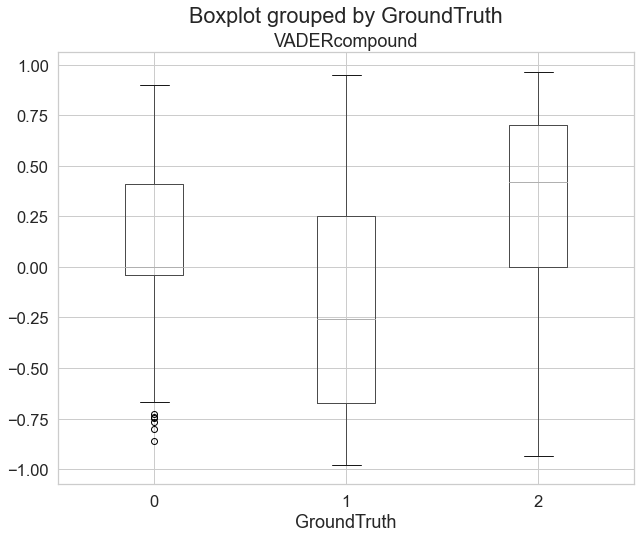

In [114]:
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

So, this changes NOTHING. I guess not many rows have emojis, and/or those rows were already predicted correctly.

* Underpredicting neutral
* Underpredicting negative
* Overpredicting positive

Baseline: Majority Class Prediction
* Majority class prediction F-score, micro average: 0.606
* Majority class prediction F-score, macro average: 0.252

VADER-base, untuned:
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

VADER-base, lexicon with updated sentiment terms
* VADER_lex_ F-score, micro average: 0.563
* VADER_lex_ F-score, macro average: 0.521

VADER-base w emoji lexicon
* VADER-base w emoji lexicon, F-score, micro average: 0.563
* VADER-base w emoji lexicon, F-score, macro average: 0.521


# Find and Remove more News
Ok, so we discovered when dealing with the emojis that several of them are reliable indicators of news articles or other irrelevant rows:
* 🎙️: audio broadcasts, esp. podcasts
* 🆕: new infomration
* 📡: on the radar
* 📊: data given
* 📅: event schedule   #DO THIS ONE LATER


In [ ]:
## IN THE FULL DATASET
print(check_tweets.shape)
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🆕" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count

In [207]:
my_count=0
print(x_train.shape)
for id, text in zip(x_train.id_stable, x_train["ContentClean"]):
    if "new_button" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        my_count += 1
my_count


(742, 7)


1

In [197]:
list = ["studio_microphone", "NEW_button", "satellite_antenna", "bar_chart"]
indx_list = []
# for i, text in zip(x_train.index, x_train["ContentClean"]):
#     for emj in list:
#         if emj in text:
#             indx_list.append(i)
for id, text in zip(x_train.index, x_train["ContentClean"]):
    if "bar_chart" in text:
        print(i)

indx_list


679


[]

This is not in enough rows to be worth it.

# Reset the category thresholds
I think the VADER people wanted to keep "neutral" as small as possible. That makes sense when you are talking about a simple subject. It's less useful when topics are complex (lots of pros and cons) and undecided or neutral is a viable stance to take on the subject.

So let's widen the thresholds.

In [245]:
def vader_pred_var(tweet):
    scores = sid.polarity_scores(tweet)
    comp = scores["compound"]
    if comp >= 0.1:
        return 2
    elif comp <= -.01:
        return 1
    else:
        return 0

In [246]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred_var)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

Ground Truth:
1    450
0    155
2    137
Name: y_sent, dtype: int64
Pred:
1    324
2    284
0    134
Name: VADERpred, dtype: int64


In [247]:
# Use the same "true" as above
# Get the prediction list
threshold_pred = x_train["VADERpred"].tolist()

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=threshold_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=threshold_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-threshold F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-threshold F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

Micro and Macro-Average
	VADER-threshold F-score, micro average: 0.567
	VADER-threshold F-score, macro average: 0.524



So, disappointingly, this also does very little. Because there is so much overlap, moving the threshold may help one class, but it will about equally hurt another. There has to be better separation betwteen classes in order for this to work.

NOTE: no need for boxplots, as the distribution hasn't changed.

Unfortunately, I think I have to leave the analysis there and move on to writeup. I don't have time to keep working on this now.

# Now make the selected transformations on the validate data and the full dataset.
* sid.lexicon.update(change_lex)
* replace "left behind" with "left_behind"
* replace new emojis with the text equivalent in 

# TO CONSIDER, esp. for BERT
* expand contractions
* remove links, URLs
* Replace emoji w standard text
* What to do with hashtags
* remove capitalization 
* What to do with punctuation: ! or ? should be useful for sentiment. Maybe " " for sarcasm?
* remove whitespaces
* Bertmoticon package, which is fine-tuned to the BERT model.
* remove stop words beyond the standard NLTK stop words
    * Create WordClouds to find prominant but useless words
    * Ex: days of the week and their abbreviations, month names, and the word “Twitter” 
* deal w negations
    * create a dictionary of negations so that negated words could be effectively handled
* tokenize 
* stemming (via PorterStemmer)
* REMEMBER:
    * Hashtags is filled with "No hashtags"
    * Location is filled with "English-speaking"